In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

In [3]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [4]:
sys.path.append('../../')
sys.path.append('/DMASS-analysis/measurements/code_py3/')
import esutil
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
os.chdir('../../DMASS-analysis/measurements/code_py3/')
print(os.getcwd())
from calling_catalogs import *
rootdir = '/users/PCON0003/warner785/DMASS-analysis/measurements/clustering/'
from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3


In [5]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [6]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------

In [7]:
# import DMASS in validation region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_val, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200.fits')

random_val = uniform_random_on_sphere(dmass_val, size = 50 * dmass_val.size)
# applying LSS mask 
random_val = keepGoodRegion(random_val)

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 28441.7573735908
randoms= 5864645


In [8]:
print(dmass_val['HPIX_4096']) 

[71771941 71771626 71773248 ... 72968986 72905874 72968681]


In [9]:
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

In [10]:
random_val = appendColumn(random_val, value=np.ones(random_val.size), name='WEIGHT')
randomsind_val = np.random.choice( random_val.size, size=int(random_val.size/3.) )
random_val = random_val[randomsind_val]

In [11]:
# import DMASS in training region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_train, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200train.fits')

random_train = uniform_random_on_sphere(dmass_train, size = 50 * dmass_train.size)
# applying LSS mask 
random_train = keepGoodRegion(random_train)

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 20605.043776036357
randoms= 5864645


In [12]:
random_train = appendColumn(random_train, value=np.ones(random_train.size), name='WEIGHT')
randomsind_train = np.random.choice( random_train.size, size=int(random_train.size/3.) )
random_train = random_train[randomsind_train]

In [13]:
# calling CMASS

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [14]:
cmass = train_sample

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

In [155]:
# calling systematic maps
#sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )

# location of maps: /fs/scratch/PCON0003/warner785/bwarner/
# y3a2_g_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 
# y3a2_i_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz        
# y3a2_r_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz        
# y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 

input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
input_keyword = 'y3a2_z' 
sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)


Calling catalogs >>>
y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz
reading 1/1 /fs/scratch/PCON0003/warner785/bwarner/y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz


In [156]:
print(dmass_val.dtype.names)
print()
print(sysMap.dtype.names)

('COADD_OBJECT_ID', 'RA', 'DEC', 'HPIX_4096', 'MAG_DETMODEL_G', 'MAGERR_DETMODEL_G', 'MAG_DETMODEL_R', 'MAGERR_DETMODEL_R', 'MAG_DETMODEL_I', 'MAGERR_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_Z', 'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z', 'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z', 'SOF_CM_MAG_ERR_G', 'SOF_CM_MAG_ERR_R', 'SOF_CM_MAG_ERR_I', 'SOF_CM_MAG_ERR_Z', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z', 'EXTENDED_CLASS_MASH_SOF', 'CMASS_PROB', 'WEIGHT')

('PIXEL', 'SIGNAL')


[0.83776313 0.83776313 0.84078258 ... 0.8790409  0.8790409  0.85562736]
[ 94620 281920 430556 452556 389034 323763 273012 177128 107916  74643
  47926  33264]


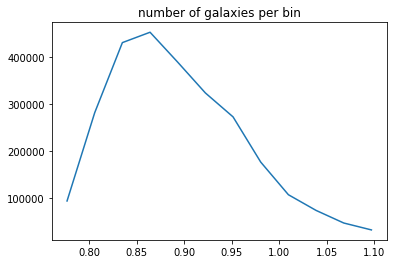

In [157]:
#Jack's method:
import matplotlib.pyplot as plt

#np.percentile()

index_mask = np.argsort(dmass_val['HPIX_4096'])
dmass_chron = dmass_val[index_mask] # ordered by hpix values

dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
#maximum = np.max(sysMap['SIGNAL'][dim_mask])
#print(minimum)
#print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

x = np.zeros(hp.nside2npix(4096))
x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]

#systematic value at galaxy location:

sysval_gal = x[dmass_chron['HPIX_4096']]
print(sysval_gal)
h,_ = np.histogram(sysval_gal , bins=pbin)
print(h)

# want this plotted:
#h/number_of_pixels_in_sysbin

fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h)
#ax.legend(chi2_reduced)
plt.title('number of galaxies per bin')
fig.savefig('gal_bin.pdf')

In [158]:
# number of galaxies in each pixel:

# dmass catalog turned into healpix map
# counting number of galaxies in each healpix pixel 
# dividing healpix pixel area --- corresponding area to 4096 resolution -- to get number density (plus mask -- later) FRACDET

# 1) galaxy number counts and area for each healpix pixel -- match healpix with area map?

#bins of systematic signal
#print(pbin)

#compute how much area is in each bin. 
#you can get the first pass estimate of this by just doing a histogram of the signal column of the sysmap with the same bins.  

sys_signal = sysMap['SIGNAL'][dim_mask]
n,_ = np.histogram(sys_signal , bins=pbin )
print('without weights:')
print(n)

#To do it properly you will need to:

#(A) make sure the mask you are using for the galaxies applied to the sysmap 
#print(LSSGoldmask.dtype.names)
#print(LSSGoldmask)

matched_sys = sysMap[dim_mask]
mask = np.zeros(hp.nside2npix(4096))
bao_mask = np.in1d(LSSGoldmask["PIXEL"], matched_sys["PIXEL"], assume_unique=False, invert=False)
mask[matched_sys["PIXEL"]] = matched_sys["SIGNAL"]

#some pixels were not in Goldmask, therefore these pixels = 0
# only include the signals of pixels of systematic within mask
BAO_sys = mask[LSSGoldmask["PIXEL"][bao_mask]]


#(B) add up the fractional coverage  (probably labelled fracgood or fracdet) in each “SIGNAL” bin, 
#rather than treating each pixel as 1. you can do this with the same histogram function by also passing the fracgood array 
#as the weights= argument 

area,_ = np.histogram(BAO_sys , bins=pbin , weights = LSSGoldmask["SIGNAL"][bao_mask])
print('with weights:')
print(area)

without weights:
[ 40183 120061 184288 191530 164503 137079 116200  75008  45709  31280
  19933  13445]
with weights:
[ 39893.203 119244.33  182997.8   190209.97  163369.19  136142.19
 115407.5    74480.5    45402.375  31056.     19794.25   13356.   ]


In [159]:
#then do the number of galaxies divided by the area:

# h = number of galaxies
#print(h)

# number density in bins: h/area
#number_density = []
#for x in range(len(h)):
#    den = h[x]/area[x]
#    number_density.append(den)
    
#Details: So the idea here is, we don’t expect the number density of galaxies to change as we look at patches with different 
#survey property values.
#So when you make these histograms you are effectively splitting the survey footprint into patches of different 
#sysmap values and you can calculate the number density of objects in each patch.
    
#print(number_density)

#If we do see this density change as a function of the sysmap, we will have to correct for it with systematics 
#weights as Su did in her paper


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:479: RuntimeWarning: invalid value encountered in _ang2pix_nest
  return pixlib._ang2pix_nest(nside, theta, phi)


without weights:
[   809  17590 212785 451571 362148 240193  99599  44319  15247   2704
    793     13]
with weights:
[8.0210938e+02 1.7463000e+04 2.1133264e+05 4.4851025e+05 3.5970594e+05
 2.3857675e+05 9.8914750e+04 4.4012500e+04 1.5150000e+04 2.6862500e+03
 7.8250000e+02 1.2750000e+01]
number of random galaxies:  [   19425   423247  5119744 10875580  8716081  5780508  2398006  1066468
   366531    64701    19347      298]
randoms number density:  [24.217395539105873, 24.236786348279217, 24.225997389039154, 24.248230670313554, 24.231129073314225, 24.229133811236846, 24.243158881764348, 24.231025276909968, 24.193465346534655, 24.08599348534202, 24.724600638977634, 23.372549019607842]
total_area:  1437949.4375
total galaxies:  34849936
total number density:  24.235856345957227
[0.99923829 1.00003837 0.99959321 1.00051058 0.99980495 0.99972262
 1.00030131 0.99980066 0.9982509  0.99381648 1.02016617 0.96437892]
normalized error:  [0.00716949 0.00153716 0.00044177 0.00030339 0.00033865 0.

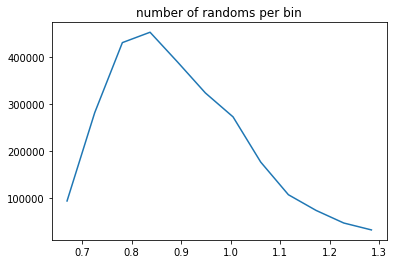

In [160]:
# now for randoms:

import matplotlib.pyplot as plt

#print(random_val.dtype.names)

# convert RA and DEC to PIXELS for randoms:
phi = random_val['RA'] * np.pi / 180.0
theta = ( 90.0 - random_val['DEC'] ) * np.pi/180.0
nside= 4096
random_pix = hp.ang2pix(nside,theta,phi,nest=True)
#print(random_pix)

index_ran_mask = np.argsort(random_pix)
random_chron = random_pix[index_ran_mask] # ordered by hpix values

dim_ran_mask = np.in1d(sysMap['PIXEL'], random_chron, assume_unique=False, invert=False)

minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.max(sysMap['SIGNAL'][dim_mask])
#print(minimum)
#print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

x = np.zeros(hp.nside2npix(4096))
x[sysMap['PIXEL'][dim_ran_mask]] = sysMap['SIGNAL'][dim_ran_mask]

#systematic value at galaxy location:

sysval_ran_gal = x[random_chron]
#print(sysval_ran_gal)
h_ran,_ = np.histogram(sysval_ran_gal , bins=pbin )
#print(h_ran)

# want this plotted:
#h/number_of_pixels_in_sysbin

fracerr = 1/np.sqrt(h_ran) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h)
#ax.legend(chi2_reduced)
plt.title('number of randoms per bin')
fig.savefig('random_bin.pdf')

sys_ran_signal = sysMap['SIGNAL'][dim_ran_mask]
n_ran,_ = np.histogram(sys_ran_signal , bins=pbin )
print('without weights:')
print(n_ran)

matched_ran_sys = sysMap[dim_ran_mask]
mask = np.zeros(hp.nside2npix(4096))
bao_mask_ran = np.in1d(LSSGoldmask["PIXEL"], matched_ran_sys["PIXEL"], assume_unique=False, invert=False)
mask[matched_ran_sys["PIXEL"]] = matched_ran_sys["SIGNAL"]

BAO_sys_ran = mask[LSSGoldmask["PIXEL"][bao_mask_ran]]

area_ran,_ = np.histogram(BAO_sys_ran , bins=pbin , weights = LSSGoldmask["SIGNAL"][bao_mask_ran])
print('with weights:')
print(area_ran)

# h = number of galaxies
print("number of random galaxies: ", h_ran)

# number density in bins: h/area
number_density_ran = []
for x in range(len(h)):
    den_ran = h_ran[x]/area_ran[x]
    number_density_ran.append(den_ran)
    
print("randoms number density: ", number_density_ran)


total_area_ran = 0
#Normalize based on total number density of used footprint:
for x in range(len(area_ran)):
    total_area_ran += area_ran[x]

print("total_area: ", total_area_ran)

# total galaxies:
total_h_ran = 0
for x in range(len(h_ran)):
    total_h_ran += h_ran[x]

print("total galaxies: ", total_h_ran)

#normalization: 
total_num_density_ran = total_h_ran/total_area_ran

print("total number density: ", total_num_density_ran)

# apply normalization: 
#print(number_density)
norm_number_density_ran = number_density_ran/total_num_density_ran
print(norm_number_density_ran)

fracerr_ran = np.sqrt(h_ran) #1 / sqrt(number of randoms cmass galaxies in each bin)
fracerr_ran_norm = (fracerr_ran/area_ran)/total_num_density_ran
print("normalized error: ", fracerr_ran_norm)

total_area:  1131353.296875
total galaxies:  2686338
normalized error:  [0.00324736 0.00187527 0.0015101  0.0014895  0.00160791 0.00176019
 0.00190675 0.00237979 0.00304721 0.00370499 0.00465784 0.00575107]
total number density:  2.374446609578233
[1.0510742  0.98099531 0.98995882 0.98997396 0.99450782 1.00135089
 1.01203428 1.01509191 1.0134947  0.99258899 1.0018734  1.33904345]


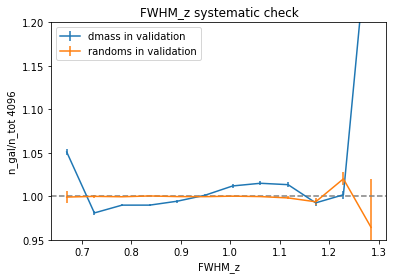

In [161]:
# *****Creating the figure******:

#Also, we usually normalize the plots to the total number density of the total footprint considered. 
#so that we expect the final result to be a flat line at y=1.

total_area = 0
#Normalize based on total number density of used footprint:
for x in range(len(area)):
    total_area += area[x]

print("total_area: ", total_area)

# total galaxies:
total_h = 0
for x in range(len(h)):
    total_h += h[x]

print("total galaxies: ", total_h)

#normalization: 
total_num_density = total_h/total_area

fracerr = np.sqrt(h)
fracerr_norm = (fracerr/area)/total_num_density
print("normalized error: ", fracerr_norm)


print("total number density: ", total_num_density)

# apply normalization: 
#print(number_density)
norm_number_density = number_density/total_num_density
print(norm_number_density)

import matplotlib.pyplot as plt
#figure of systematics:

fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, norm_number_density, yerr=fracerr_norm, label = "dmass in validation")
ax.errorbar( pcenter, norm_number_density_ran, yerr=fracerr_ran_norm, label = "randoms in validation")
plt.legend()
plt.xlabel("FWHM_z")
plt.ylabel("n_gal/n_tot 4096")
plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=0.95)
plt.axhline(y=1, color='grey', linestyle='--')
plt.title('FWHM_z systematic check')
fig.savefig('FWHM_z.pdf')

In [ ]:
# add limits to narrow range of x axis
# use first and last percentile for limits instead of min max of x-axis
# np.percentile() -- for less noisy plot ** 2nd and 99th

In [40]:
# don't run: check

#dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

print(sysMap['PIXEL'][dim_mask])
print(dmass_chron['HPIX_4096'])

[    35370     35456     35458 ... 150977211 150977212 150977214]
[35370 35370 35456 ... 150977212 150977212 150977214]


In [11]:
# not this one

minimum = np.min(sysMap['PIXEL'])
maximum = np.max(sysMap['PIXEL'])
print(sysMap['SIGNAL'])
#np.min(sysMap['PIXEL'])
#np.max(sysMap['PIXEL'])
minpix = np.min(dmass_val['HPIX_4096'])
maxpix = np.max(dmass_val['HPIX_4096'])
#pbin = np.linspace(minimum, maximum, 13)
print(minpix)
print(maxpix)
#M, _ = np.histogram(dmass_val, bins=pbin) #shaded gray in plot

#number density of each
sysMaps_len = sysMap['PIXEL'].size
dmass_len = dmass_val['HPIX_4096'].size
print(dmass_len)

[1.0857818 1.0857818 1.0857818 ... 1.0808538 1.0808538 1.0808538]
35370
150977214
2741190


In [12]:
#unnecessay

#compare two arrays: mask first array
# sort dmass value to be chronilogical order:
index_mask = np.argsort(dmass_val['HPIX_4096'])

#print(index_mask)
#hpix_smallest = dmass_val['HPIX_4096'][2111516]

dmass_chron = dmass_val[index_mask] # ordered by hpix values

dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)
                    
#print(dim_mask)
#sys_pix = sysMap['PIXEL'][dim_mask]
#print(sys_pix)

In [12]:
print(dmass_chron['HPIX_4096'])

[35370 35370 35456 ... 150977212 150977212 150977214]


In [ ]:
# don't use this one

dmass_signal = []

for x in range(sysMaps_len):
    if sysMap['PIXEL'][x] > minpix or sysMap['PIXEL'][x] == minpix:
        if sysMap['PIXEL'][x] < maxpix or sysMap['PIXEL'][x] == maxpix:
            for y in range(dmass_len):
                if dmass_val['HPIX_4096'][y] == sysMap['PIXEL'][x]:
                    dmass_signal.append(sysMap['SIGNAL'][x])
                    
print(dmass_signal)

In [ ]:
# don't run this
# save the corresponding dmass signal
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_signal.fits', dmass_signal, overwrite=True)

In [ ]:
# notes
# number of galaxies in each pixel:

# dmass catalog turned into healpix map
# counting number of galaxies in each healpix pixel -- some numpy?
# dividing healpix pixel area --- corresponding area to 4096 resolution -- to get number density (plus mask -- later) FRACDET

# 1) galaxy number counts and area for each healpix pixel -- match healpix with area map?

dmass_counts = []
dmass_healpix = []
value_last = 0
arr = dmass_chron['HPIX_4096']

#check:
count = arr[arr==dmass_chron['HPIX_4096'][0]].shape[0]
print(count)

breakpoint()
#collections counter -- 
for x in range(len(dmass_chron['HPIX_4096'])):
    value = dmass_chron['HPIX_4096'][x]
    if value != value_last:
        count = arr[arr==value].shape[0]
    dmass_counts.append(count)
    dmass_healpix.append(value)

print(dmass_counts)
print(dmass_healpix)

2
--Return--
None
> <ipython-input-13-6303d079ef40>(18)<module>()
     16 print(count)
     17 
---> 18 breakpoint()
     19 #collections counter --
     20 for x in range(len(dmass_chron['HPIX_4096'])):



ipdb>  l


     13 
     14 #check:
     15 count = arr[arr==dmass_chron['HPIX_4096'][0]].shape[0]
     16 print(count)
     17 
---> 18 breakpoint()
     19 #collections counter --
     20 for x in range(len(dmass_chron['HPIX_4096'])):
     21     value = dmass_chron['HPIX_4096'][x]
     22     if value != value_last:
     23         count = arr[arr==value].shape[0]



ipdb>  n


    [... skipped 1 hidden frame]

> /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3346)run_code()
   3344             finally:
   3345                 # Reset our crash handler in place
-> 3346                 sys.excepthook = old_excepthook
   3347         except SystemExit as e:
   3348             if result is not None:



ipdb>  c


In [ ]:
# not run
# save the dmass counts and healpix arrays
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_counts.fits', dmass_counts, overwrite=True)

outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_healpix.fits', dmass_healpix, overwrite=True)

In [13]:
# 2) match healpix map with systematic maps (using same method as above)

dim_mask = np.in1d(sysMap['PIXEL'], dmass_healpix, assume_unique=False, invert=False)
                    
#print(dim_mask)
sys_pix = sysMap['PIXEL'][dim_mask]
print(sys_pix)

NameError: name 'dmass_healpix' is not defined

In [ ]:
# 3) array with: healpix pixel value, galaxy counts, area --- binned in signal histogram
# for all signal bins : total number counts in healpix pixels / totsl area of healpix pixels used in same bin --- number density
import matplotlib.pyplot as plt

# area: 6.24178e-08 square degrees ---- from github (without masking bad regions)

minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.max(sysMap['SIGNAL'][dim_mask])

print(minimum)
print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

#another option: step through min max of pbin, bolean of pixel falls within, take average

N, _ = np.histogram(dmass_counts, bins=pbin)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, number_density, yerr=fracerr)
#ax.legend(chi2_reduced)
plt.title('Systematic Test')
fig.savefig('SystematicTest1.pdf')

# do the same with randoms
print(random_val.dtype.names)

In [ ]:
# take all objects in each bin of systematic value